In [ ]:
import torch 
import torchvision.transforms as T
import torchvision
import torch.nn as nn
import torchvision.datasets
from torch.nn.modules.container import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
# architecture configuration
#
#
# tuple : single convolutional layer. filter size , numbers of layers , stride and padding define accordingly
# string : Maxxpooling "M", Average pooling "A"
# list:
#      - containg two elements , two layers without repetation
#      - containg three elements, two layers with repetation defined by last element in the list 

architecture_config=[
                     (7,64,2,3),
                     "M",
                     [(3,64,1,1),(3,64,1,1),3],
                     [(3,128,2,1),(3,128,1,1)],
                     [(3,128,1,1),(3,128,1,1),3],
                     [(3,256,2,1),(3,256,1,1)],
                     [(3,256,1,1),(3,256,1,1),5],
                     [(3,512,2,1),(3,512,1,1)],
                     [(3,512,1,1),(3,512,1,1),2],
                     "A"
]


In [ ]:
# if GPU is available use cuda otherwise use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#loading and transforming the images in cifar10 dataset
transform_train = T.Compose([T.Resize((224,224),interpolation=T.InterpolationMode.BICUBIC), T.ToTensor(), T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
transform_test = T.Compose([T.Resize((224,224),interpolation=T.InterpolationMode.BICUBIC), T.ToTensor(), T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([50, 3, 224, 224])


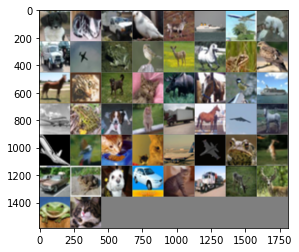

tensor([5, 3, 9, 2, 4, 8, 0, 5, 9, 0, 6, 2, 4, 7, 6, 2, 7, 3, 5, 3, 4, 7, 2, 8,
        0, 6, 5, 3, 9, 7, 0, 7, 0, 2, 3, 3, 0, 0, 6, 4, 1, 6, 5, 1, 3, 9, 4, 4,
        6, 3])
dog   cat   truck bird  deer  ship  plane dog   truck plane frog  bird  deer  horse frog  bird  horse cat   dog   cat   deer  horse bird  ship  plane frog  dog   cat   truck horse plane horse plane bird  cat   cat   plane plane frog  deer  car   frog  dog   car   cat   truck deer  deer  frog  cat  


In [ ]:



# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:

# class defining simple neural network containing conv layer with batch norm and ReLu as activation layer
class Simple_network(nn.Module):
  def __init__(self,input_channels,output_channels,**kwargs):
    super(Simple_network,self).__init__()
    self.conv=nn.Conv2d(in_channels=input_channels,out_channels=output_channels,bias=False,**kwargs)
    self.batchNorm=nn.BatchNorm2d(output_channels)
    self.Relu=nn.ReLU()
  
  def forward(self,x):
    return self.Relu(self.batchNorm(self.conv(x)))


# class using those simple neural network to create Residual blocks present in Resnet
class Residual_block(nn.Module):
  def __init__(self,in_channels,architecture):
    super(Residual_block,self).__init__()
    self.in_channels=in_channels
    self.architecture=architecture
    self.layers=self.create_layers(architecture)
    if len(architecture)<=2:
      first_layer=architecture[0]
      self.conv_layer=nn.Conv2d(in_channels=self.in_channels,out_channels=first_layer[1],kernel_size=1,padding=0,stride=2)
    self.Relu_=nn.ReLU()
  
  def create_layers(self,architecture):
    layers=nn.ModuleList()
    conv1=architecture[0]
    conv2=architecture[1]
    repeats=1
    # creating residual blocks based on architecture configuration define above 
    if len(architecture)>2:
      repeats=architecture[2]
    in_channels=self.in_channels
    for i in range(repeats):
      layers+=[
              nn.Sequential(
                  Simple_network(input_channels=in_channels,output_channels=conv1[1],kernel_size=conv1[0],padding=conv1[3],stride=conv1[2]),
                  Simple_network(input_channels=conv1[1],output_channels=conv2[1],kernel_size=conv2[0],padding=conv2[3],stride=conv2[2])
              )]
      in_channels=conv2[1]
    return layers
  
  def forward(self,x):
    if len(self.architecture)>2:
      for layer in self.layers:
        # skip connections
        x=self.Relu_(layer(x)+x)
    else:
      for layer in self.layers:
        # skip connections for those layers with stride of 2 
        x=self.Relu_(layer(x)+self.conv_layer(x))
    
    return x


In [ ]:
# Creating entire resnet model using Residual blocks and skip connection based on the network architecture define above
class Resnet(nn.Module):
  def __init__(self,architecture_config):
      super(Resnet,self).__init__()
      self.in_channels=3
      self.architecture=architecture_config
      self.Resnet_model=self.create_model(self.architecture)
      self.fc=nn.Linear(6*6*512,10)
      self.softmax=nn.Softmax(dim=1)


  def forward(self,x):
    outputs=[]
    for layers in self.Resnet_model:
      x=layers(x)
      outputs.append(x)
    x=torch.flatten(x,start_dim=1)
    x=self.fc(x)
    return x,outputs

  def create_model(self,architecture):
    layers=nn.ModuleList()
    in_channels=self.in_channels
    for arch in architecture:
      if type(arch)==tuple:
        layers+=[
                 Simple_network(input_channels=in_channels,output_channels=arch[1],kernel_size=arch[0],padding=arch[3],stride=arch[2])
        ]  
        in_channels=arch[1]
      elif type(arch)==list:
        conv_2=arch[1]
        layers+=[
                 Residual_block(in_channels=in_channels,architecture=arch)
        ]
        in_channels=conv_2[1]
      elif type(arch)==str and arch=="M" :
        layers+=[nn.MaxPool2d(kernel_size=(2,2),stride=2)]
      elif type(arch)==str and arch=="A" :
        layers+=[nn.AvgPool2d(kernel_size=(2,2),stride=1)]
    
    return layers


In [ ]:
model=Resnet(architecture_config).to(device)

In [ ]:
model

Resnet(
  (Resnet_model): ModuleList(
    (0): Simple_network(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (Relu): ReLU()
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Residual_block(
      (layers): ModuleList(
        (0): Sequential(
          (0): Simple_network(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (Relu): ReLU()
          )
          (1): Simple_network(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (Relu): ReLU()
          )
       

In [ ]:
model.load_state_dict(torch.load("/content/gdrive/MyDrive/visualize_model_lr0001.pth"))

<All keys matched successfully>

In [ ]:
# Hyperparameters 
learning_rate=0.0001
num_epochs=30
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9)

In [ ]:
# # training loop
# for epochs in range(num_epochs):
#   for i,(images,labels) in enumerate(trainloader):
#     images = images.to(device)
#     labels = labels.to(device)
#     outputs,_ = model(images)
#     loss = criterion(outputs, labels)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     _,prediction=torch.max(outputs,1)
#     train_acc = torch.sum(prediction == labels)/batch_size
#     if i%200==0:
#         print("epochs",epochs, "iteration",i,"loss",loss.item(),"accurracy",train_acc.item())

# # saving trained model in google drive 
# torch.save(model.state_dict(),"/content/gdrive/MyDrive/visualize_model_lr0001.pth")

epochs 0 iteration 0 loss 2.7099485397338867 accurracy 0.11999999731779099
epochs 0 iteration 200 loss 1.7085866928100586 accurracy 0.41999998688697815
epochs 0 iteration 400 loss 1.5558042526245117 accurracy 0.5
epochs 0 iteration 600 loss 1.7718778848648071 accurracy 0.4399999976158142
epochs 0 iteration 800 loss 1.8518017530441284 accurracy 0.3999999761581421
epochs 1 iteration 0 loss 1.1880367994308472 accurracy 0.5399999618530273
epochs 1 iteration 200 loss 1.3499352931976318 accurracy 0.5
epochs 1 iteration 400 loss 1.6579079627990723 accurracy 0.3400000035762787
epochs 1 iteration 600 loss 1.345424771308899 accurracy 0.5999999642372131
epochs 1 iteration 800 loss 1.1809487342834473 accurracy 0.5399999618530273
epochs 2 iteration 0 loss 1.1296024322509766 accurracy 0.6399999856948853
epochs 2 iteration 200 loss 1.223755121231079 accurracy 0.5799999833106995
epochs 2 iteration 400 loss 1.0878149271011353 accurracy 0.5799999833106995
epochs 2 iteration 600 loss 1.1550308465957642 a

In [ ]:
total_iteration=0
total_accuracy=0
loss_value=0
y_true=[]
y_predicted=[]
y_true_binary=[]
y_predicted_binary=[]

# testing loop
for i,(images,labels) in enumerate(testloader):
  images = images.to(device)
  labels = labels.to(device)
  outputs,_ = model(images)
  _,prediction=torch.max(outputs,1)
  loss = criterion(outputs, labels)
  test_acc = torch.sum(prediction == labels)/batch_size
  total_accuracy+=test_acc.item()
  loss_value+=loss.item()
  total_iteration=i
  if (i+1)% 100==0:
    print("iteration",i,"loss",loss.item(),"accurracy",test_acc.item())
  y_true.extend(labels.to("cpu"))
  y_predicted.extend(prediction.to("cpu"))
    
print("average accuracy : ",total_accuracy/total_iteration)
print("average loss over test data : ", loss_value/total_iteration)

iteration 99 loss 1.1436152458190918 accurracy 0.7799999713897705
iteration 199 loss 1.206396222114563 accurracy 0.7199999690055847
average accuracy :  0.7642210844773144
average loss over test data :  1.1092501055056125


Average f1 score : 0.8083158295827328
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1000
           1       0.93      0.88      0.90      1000
           2       0.68      0.79      0.73      1000
           3       0.72      0.55      0.62      1000
           4       0.76      0.78      0.77      1000
           5       0.70      0.76      0.73      1000
           6       0.86      0.86      0.86      1000
           7       0.89      0.82      0.85      1000
           8       0.91      0.87      0.89      1000
           9       0.90      0.88      0.89      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

[[888   7  50   7   9   2   4   2  24   7]
 [ 29 880  10   4   4   3   3   2  16  49]
 [ 51   0 791  19  46  40  26  15   5   7]
 [ 21   3  83 554  69 177  56  21   5  11]
 [ 22   1  79  26 776  32  34  

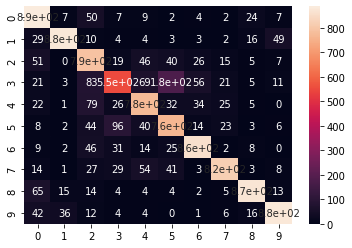

In [ ]:
# cf_matrix=confusion_matrix(y_true, y_predicted)
# print("Average f1 score :",f1_score(y_true, y_predicted,labels=[0,1,2,3,4,5,6,7,8,9],average="macro"))
# print(classification_report(y_true, y_predicted, labels=[0,1,2,3,4,5,6,7,8,9],zero_division=0))
# print(cf_matrix)
# sns.heatmap(cf_matrix, annot=True)

In [ ]:
# output_visualize=[]
# for i,(images,labels) in enumerate(testloader):
#   images = images.to(device)
#   labels = labels.to(device)
#   output_visualize.append(images)
#   outputs,output_ = model(images)
#   output_visualize.extend(output_)
#   break

In [ ]:
# len(output_visualize)

11

In [ ]:
# output_list=[]
# for each_element in output_visualize:
#   output_list.append(each_element.to("cpu").detach().numpy())

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def format_axes(fig,output,layer=0):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=False, labelleft=False)
        if i==0:
          image=np.ones(shape=((output[i][0]).shape[1],(output[i][0]).shape[2],3))
          image[:,:,0]=output[i][0,0]
          image[:,:,1]=output[i][0,1]
          image[:,:,2]=output[i][0,2]
          image=(image*0.5+0.5)
          ax.imshow(image)
        else:
          ax.imshow(output[i][0,layer],cmap="gray")

def image_visualization(image,number_of_plots=(1,11),layer=0):

  # image=transform_test(image)
  image= image.to(device)
  _,output_list = model(image)
  output_=[]
  output_.append(image.to("cpu").detach().numpy())
  for each_element in output_list:
    output_.append(each_element.to("cpu").detach().numpy())
  fig = plt.figure()
  x,y=number_of_plots
  gs = GridSpec(x, y, figure=fig,left=0,bottom=0,right=5,top=5,wspace=0,hspace=0.1)
  for i in range(x):
    for j in range(y):
      fig.add_subplot(gs[i, j])
  # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
  # fig.suptitle("GridSpec")
  format_axes(fig,output_,layer)

  plt.show()

  # fig=plt.figure(figsize=(10,10), dpi=200)
  
  # axarr= fig.subplots(x,y)
  # for i in range(x):
  #   for j in range(y):
  #     axarr[i,j].imshow(output_[i+j][0,0],cmap="gray")

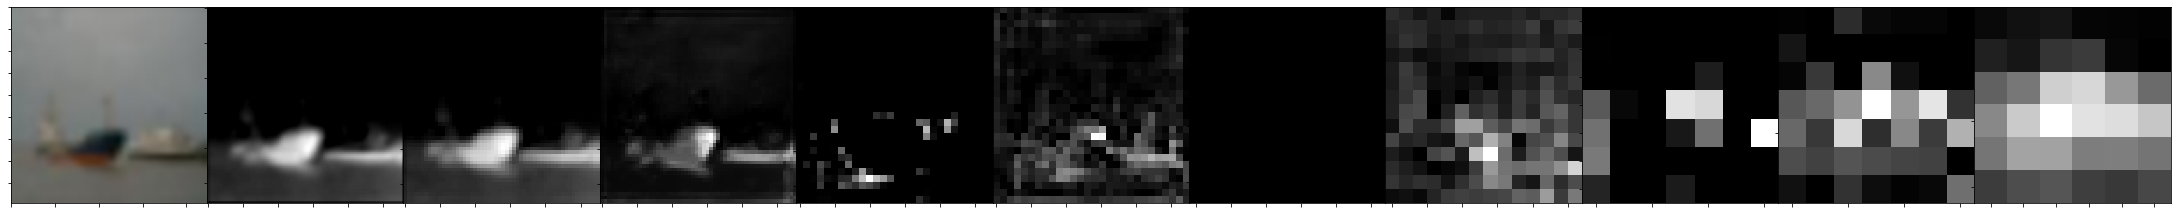

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
image=images[0:1,:,:,:]
image_visualization(image,layer=0)

In [ ]:
# image.shape

In [ ]:
# def same_batch_plt(numpy_output,number_of_plots=(2,5),no_image=0):
#   fig=plt.figure(figsize=(10,10), dpi=200)
#   x,y=number_of_plots
#   axarr= fig.subplots(x,y)
#   for i in range(x):
#     for j in range(y):
#       axarr[i,j].imshow(numpy_output[no_image,(i+j)],cmap="gray")




In [ ]:
# output_list[0].shape

(50, 3, 224, 224)

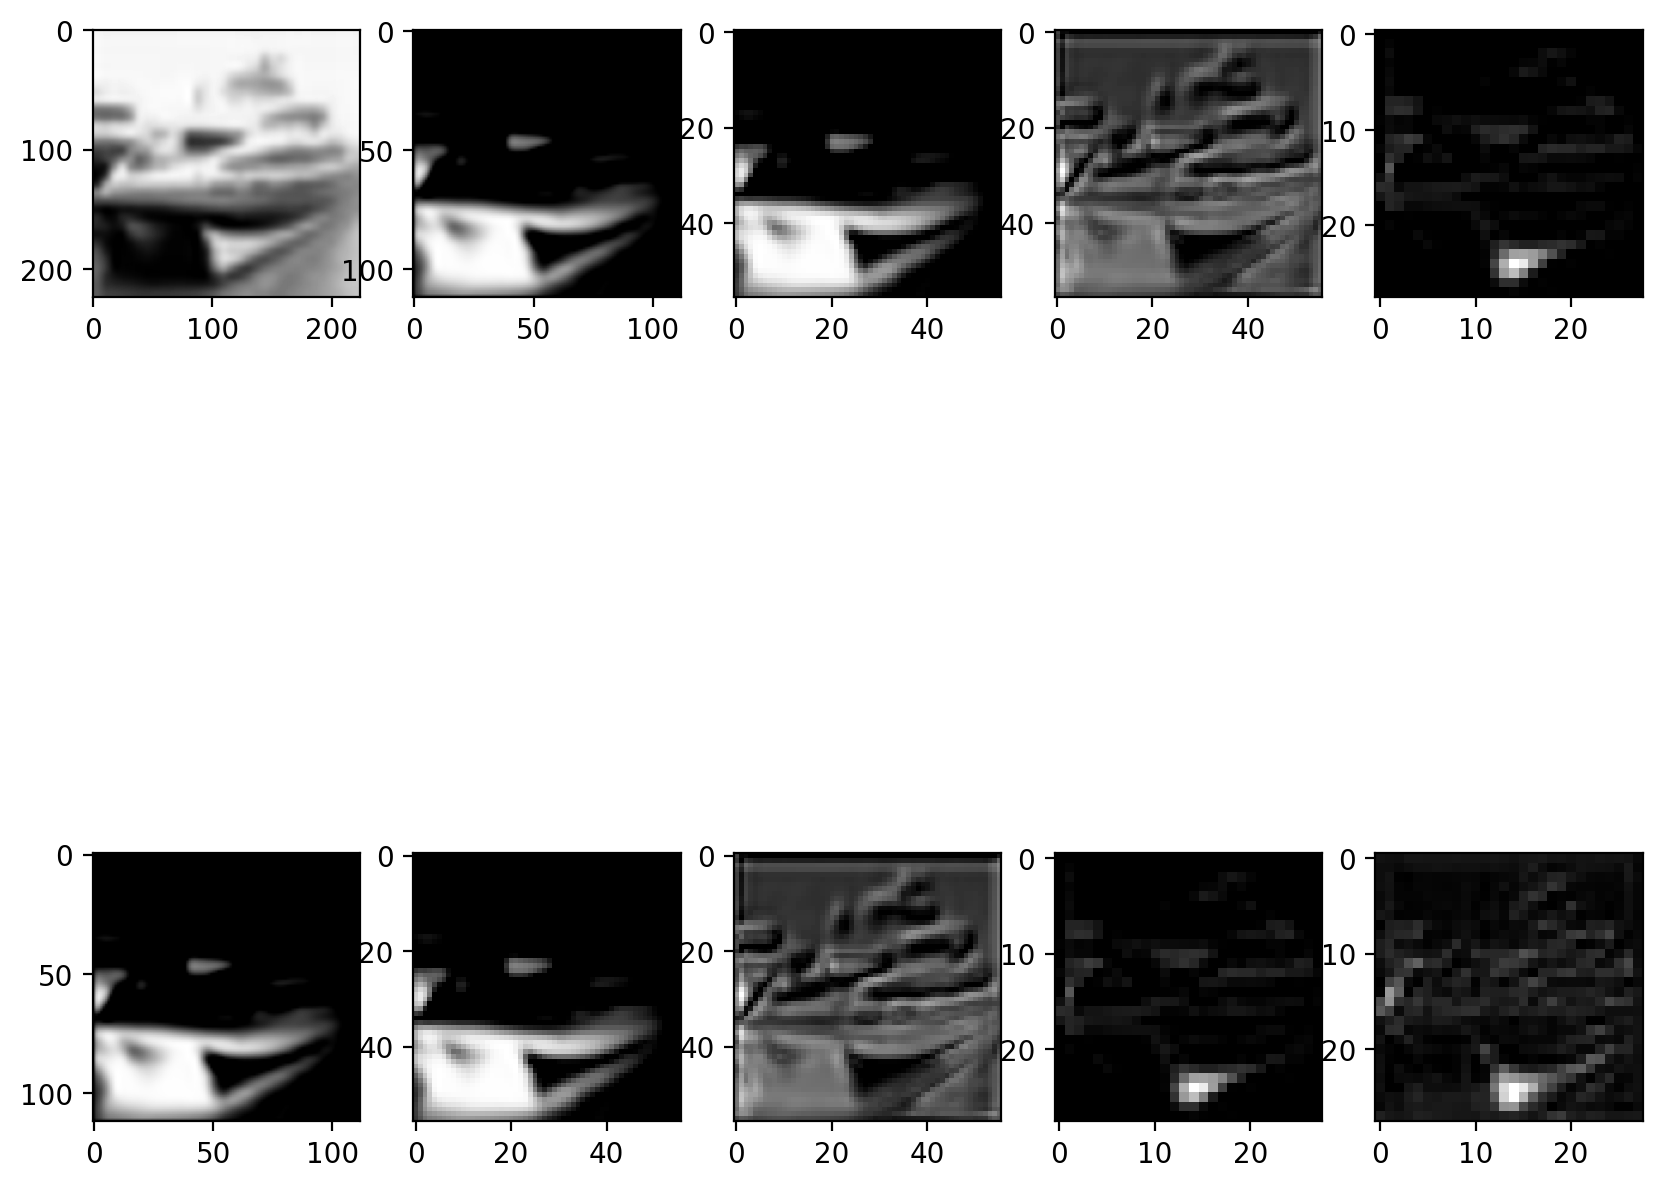

In [ ]:
# arcoss_batch_plt(output_list,number_of_plots=(2,5),image=1)

In [ ]:
# og = (torch.arange(3).reshape(-1, 1),
#           torch.arange(3).reshape(1, -1))

In [ ]:
# (torch.arange(9).reshape(-1,1)).shape

torch.Size([9, 1])

In [ ]:
# kernel_size=4
# in_channels=3
# out_channels=5
# factor = (kernel_size + 1) // 2
# if kernel_size % 2 == 1:
#     center = factor - 1
# else:
#     center = factor - 0.5
# og = (torch.arange(kernel_size).reshape(-1, 1),
#       torch.arange(kernel_size).reshape(1, -1))
# filt = (1 - torch.abs(og[0] - center) / factor) * \
#         (1 - torch.abs(og[1] - center) / factor)
# print(filt)
# # weight = torch.zeros((in_channels, out_channels,kernel_size, kernel_size))
# # weight[range(in_channels), range(out_channels), :, :] = filt

tensor([[0.0625, 0.1875, 0.1875, 0.0625],
        [0.1875, 0.5625, 0.5625, 0.1875],
        [0.1875, 0.5625, 0.5625, 0.1875],
        [0.0625, 0.1875, 0.1875, 0.0625]])
